In [2]:
import numpy as np
import pandas as pd

# Read datasets
heartDF = pd.read_csv("./data/heart_statlog_cleveland_hungary_final.csv")
wineDF = pd.read_csv("./data/winequality-red.csv")

# Preprocess datasets
wineDF['label'] = wineDF['quality'].apply(lambda x: 'good' if x > 6 else 'bad')
wineDF.drop('quality', axis=1)

wine_Y = wineDF['label'].values
wine_X = wineDF.drop('label', axis=1).values

heartDF['target'] = heartDF['target'].apply(lambda x: 'heart disease' if x else 'normal')
heart_Y = heartDF['target'].values
heart_X = heartDF.drop('target', axis=1).values

In [3]:
# Standardize datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
wine_X = scaler.fit_transform(wine_X)
heart_X = scaler.fit_transform(heart_X)

In [4]:
# Get the dataset split for training the models
from sklearn.model_selection import train_test_split
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(wine_X, wine_Y, test_size=0.3, stratify=wine_Y)
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(heart_X, heart_Y, test_size=0.3, stratify=heart_Y)

In [5]:
# Get the best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

def get_best_params_LogisticRegresion(X_train, X_test, y_train, y_test, count=5):
    # Define parameter grid
    param_grid = {
        'C': np.logspace(-3,3, 7),  # Regularization parameter, only relevant if  'penalty' != None
        'penalty': ['l1', 'l2', 'elasticnet', None],  # Penalty options
        'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga', 'newton-cholesky'],  # Algorithms
        'max_iter': [100, 500, 1000] 
    }

    # Create a Logistic Regression model
    logreg = LogisticRegression()
    best_model = None
    best_params = dict()
    for i in range(0, count):
        # Create GridSearchCV
        grid_search = GridSearchCV(logreg, param_grid, cv=10, n_jobs=4)
        # Suppress warnings for convergence, fit failed or invalid solver for current algorithm
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            warnings.filterwarnings("ignore", category=FitFailedWarning)
            warnings.filterwarnings("ignore", category=UserWarning)
            # Fit the grid search to the data
            grid_search.fit(X_train, y_train)

        # Get the best model
        if best_model is None or grid_search.best_score_ > best_model.score(X_test, y_test):
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
    return best_params


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def fit_and_predict(hyperparameters, X_train, X_test, y_train, y_test, count=5):
    if hyperparameters['penalty'] == None and 'C' in hyperparameters:
        hyperparameters.pop('C')

    best_model = None
    cm = None
    y_pred = None
    report = None
    for i in range(0, count):
        # Create the model with given hyperparameters and train it
        logreg = LogisticRegression(**hyperparameters)
        logreg.fit(X_train, y_train)

        if best_model is None or logreg.score(X_test, y_test) > best_model.score(X_test, y_test):
            best_model = logreg

            # Make predictions on test data
            y_pred = logreg.predict(X_test)

            # Get the confusion matrix and report
            cm = confusion_matrix(y_test, y_pred).ravel()
            report = classification_report(y_test, y_pred)
    return cm, report, y_pred

In [11]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix, cmap=plt.cm.Blues):
    # Calculate the values for the squares
    tp, fp, fn, tn = confusion_matrix

    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow([[tp, fp], [fn, tn]], interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Add annotations
    plt.xticks([0, 1], ['Predicted Positive', 'Predicted Negative'])
    plt.yticks([0, 1], ['Actual Positive', 'Actual Negative'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.text(0, 0, tp, ha='center', va='center', color='white')
    plt.text(1, 0, fp, ha='center', va='center', color='black')
    plt.text(0, 1, fn, ha='center', va='center', color='black')
    plt.text(1, 1, tn, ha='center', va='center', color='white')

    plt.show()

In [7]:
# Get best hyper-parameters for wine dataset and heart dataset
wine_best_params = get_best_params_LogisticRegresion(X_train_wine, X_test_wine, y_train_wine, y_test_wine)
heart_best_params = get_best_params_LogisticRegresion(X_train_heart, X_test_heart, y_train_heart, y_test_heart)


In [17]:
# Get results and performance metrics
wine_cm, wine_report, wine_results = fit_and_predict(wine_best_params, X_train_wine, X_test_wine, y_train_wine, y_test_wine)
heart_cm, heart_report, _ = fit_and_predict(heart_best_params, X_train_heart, X_test_heart, y_train_heart, y_test_heart)

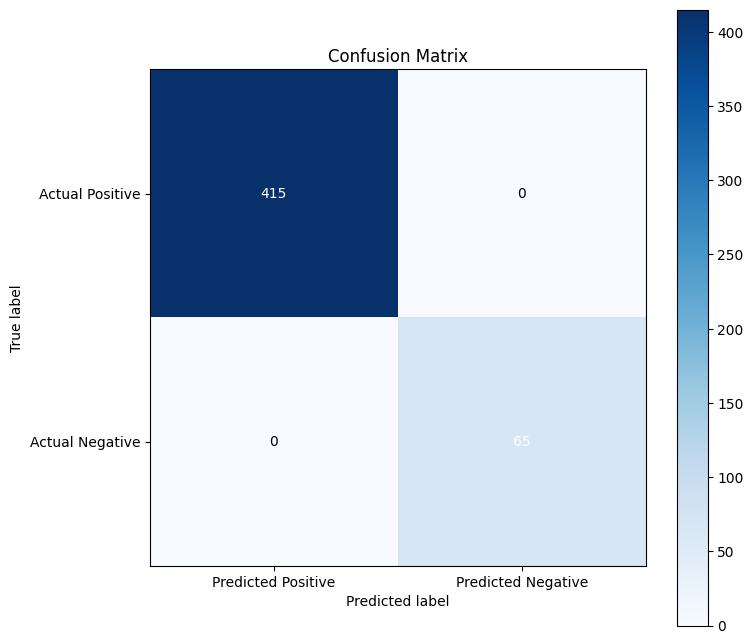

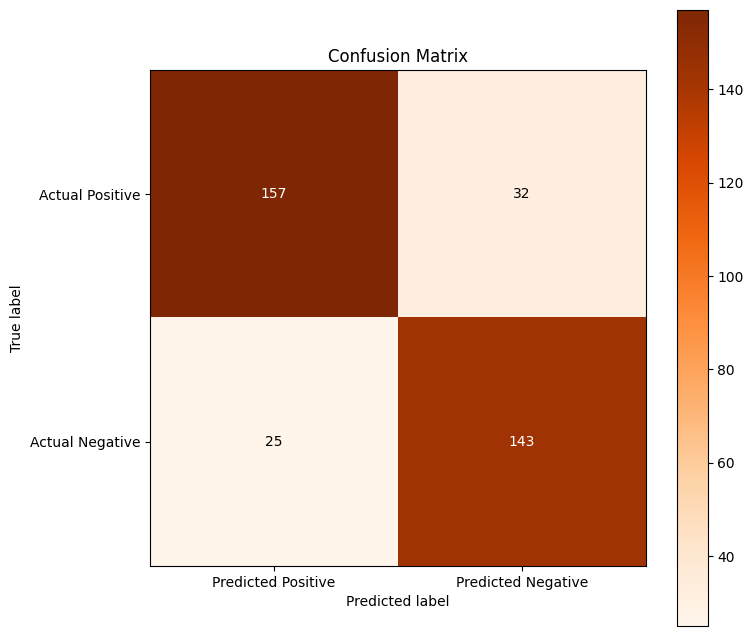

In [14]:

plot_confusion_matrix(wine_cm)
plot_confusion_matrix(heart_cm, cmap=plt.cm.Oranges)